# Interlayer backprop

The plan:
1. get multi-layer activations for validation set
1. get multi-layer activations for task datasets
1. calculate PCs from valid_acts for layer1
1. use the PCs from layer1 as a linear probe on top of the layer1 activations to produce logits for each PC - this is just a temporary layer to help with our objective 
1. run the layer0 validation activations through layer1 with its linear probe, storing the gradients
1. create a fake loss for each of the logits whereby the difference between a small perturbation is calculated. The mean is found across the dataset.
1. back propagate to the input activations and hopefully find the components which maximally activate each of the PCs in the next layer 

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1922977544
set_all_seeds(seed)
print(seed)

3868043550


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


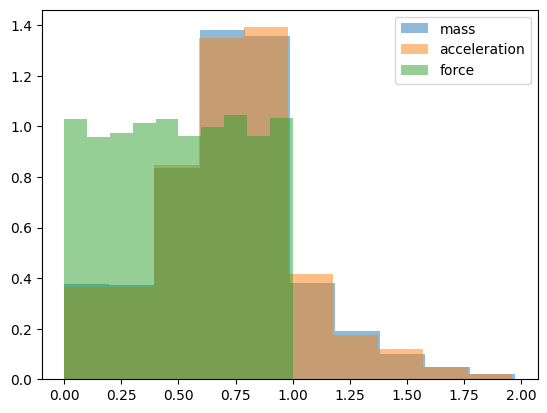

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

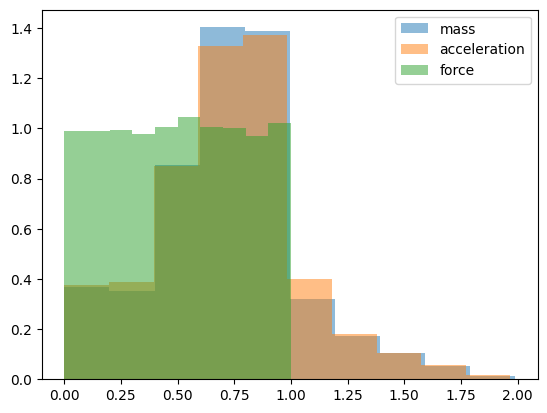

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

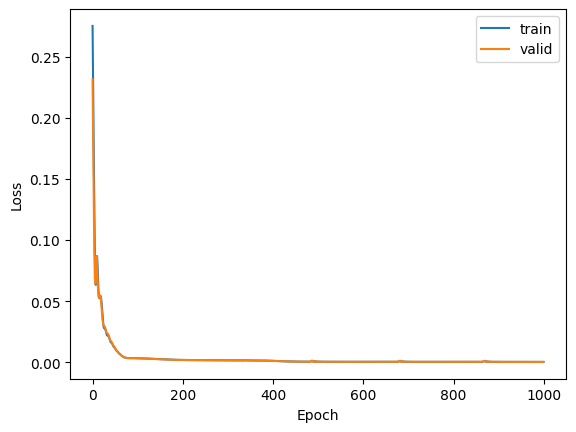

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0003)

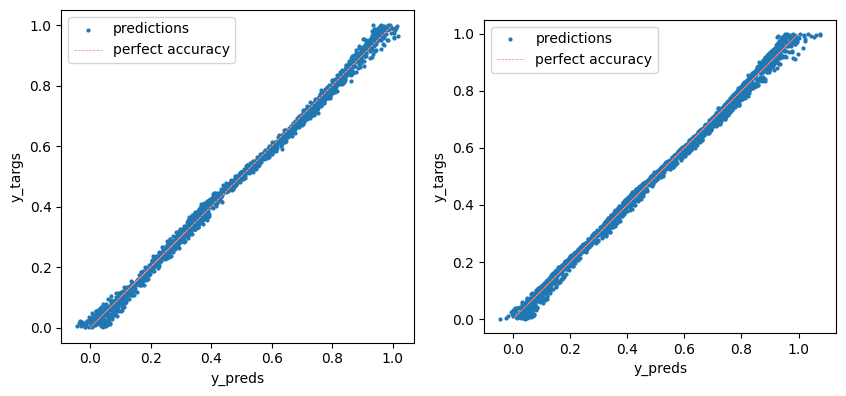

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [17]:
valid_ios = capture_intermediate_outputs(model, X_valid)
task_ios = capture_intermediate_outputs(model, task_inputs)

Now we'd like to compare the principal components at `layers.0.act` with those from `layers.1.act` I think.

In [18]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [19]:
task_acts = {}
task_acts["0"] = task_ios["layers.0.act"]
task_acts["1"] = task_ios["layers.1.act"]
task_acts["0"].shape, task_acts["1"].shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [20]:
valid_acts = {}
valid_acts["0"] = valid_ios["layers.0.act"]
valid_acts["1"] = valid_ios["layers.1.act"]
valid_acts["0"].shape, valid_acts["1"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [21]:
valid_pcs = {}
valid_vars = {}
valid_pcs["0"], valid_vars["0"] = get_pcs(valid_acts["0"])
valid_pcs["1"], valid_vars["1"] = get_pcs(valid_acts["1"])
valid_pcs["0"].shape, valid_pcs["1"].shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [22]:
def get_pc_acts(pcs, acts):
    pc_acts = (pcs.T[None, :] * acts[:, None, :]).sum(-1)
    return pc_acts

In [23]:
valid_pc_acts = {}
valid_pc_acts["0"] = get_pc_acts(valid_pcs["0"], valid_acts["0"])
valid_pc_acts["1"] = get_pc_acts(valid_pcs["1"], valid_acts["1"])
valid_pc_acts["0"].shape, valid_pc_acts["1"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [24]:
valid_ios["layers.0.act"].shape, valid_ios["layers.1.act"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [197]:
def copy_layer(layer_to_copy):
    new_layer = LinearLayer(
        layer_to_copy.linear.in_features,
        layer_to_copy.linear.out_features,
        use_act=True,
    )
    new_layer.load_state_dict(layer_to_copy.state_dict())
    return new_layer


class ScaffoldNet(nn.Module):
    def __init__(self, layer_to_examine, pcs, inputs, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer = copy_layer(layer_to_examine).requires_grad_(False)
        self.pcs = pcs.clone().requires_grad_(False)
        self.inputs = inputs.clone().requires_grad_(True)

    def forward(self):
        x = self.layer(self.inputs)
        out = get_pc_acts(self.pcs, x)
        return out


def scaffold_loss(out, eps=1e-1):
    target = out.clone() + torch.rand_like(out) * eps  # creating some pseudo loss
    loss = torch.mean((out - target).abs())
    return loss


scaffold_model = ScaffoldNet(model.layers[1], valid_pcs["1"], valid_ios["layers.0.act"])

out = scaffold_model()
loss = out[:, 0].mean()
loss.backward()
input_gradients = scaffold_model.inputs.grad

In [198]:
act_pcs, act_pc_vars = get_pcs(input_gradients)

<BarContainer object of 16 artists>

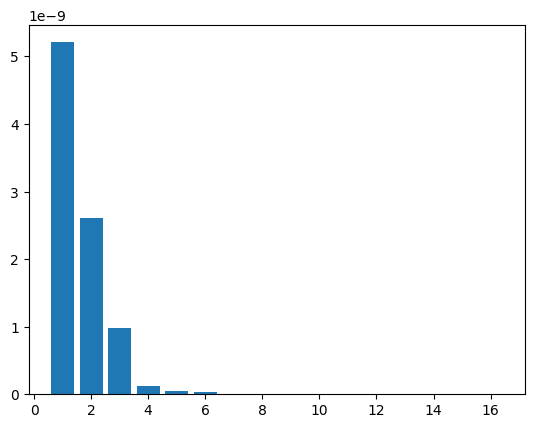

In [199]:
plt.bar(range(1, 17), act_pc_vars.numpy())

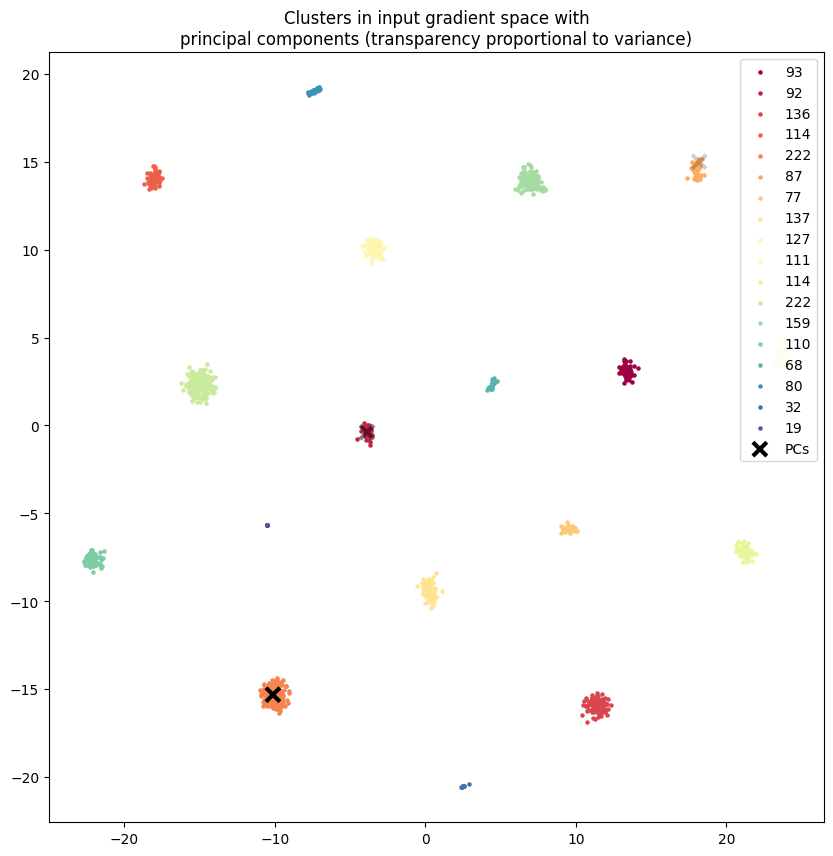

In [235]:
import pacmap
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(figsize=(10, 10))

embedding = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, save_tree=True
)

# fit the data (The index of transformed data corresponds to the index of the original data)
reduced_data = embedding.fit_transform(input_gradients.numpy(), init="pca")
# reduced_data = embedding.transform(input_gradients.numpy())
reduced_pcs = embedding.transform(act_pcs.numpy())

db = DBSCAN(eps=0.9, min_samples=5).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for cluster_label, color in zip(unique_labels, colors):
    if cluster_label == -1:
        # Black used for noise.
        color = [0, 0, 0, 1]

    class_member_mask = labels == cluster_label

    xy = reduced_data[class_member_mask & core_samples_mask]
    ax.scatter(
        xy[:, 0],
        xy[:, 1],
        s=5,
        alpha=1.0,
        marker="o",
        color=tuple(color),
        label=f"{class_member_mask.sum()}",
    )

alphas = act_pc_vars / act_pc_vars.max()
ax.scatter(
    reduced_pcs[:, 0],
    reduced_pcs[:, 1],
    s=100,
    lw=3,
    alpha=alphas,
    marker="x",
    color="k",
    label="PCs",
)

ax.set_title(
    "Clusters in input gradient space with\nprincipal components (transparency proportional to variance)"
)
_ = ax.legend(loc="upper right")

Ok so what I'm taking from this:
- Examples seem to only activate on one principal component - hence why the PCs line up with the clusters.
- Looking at the relative number of examples in each cluster, it seems that the highest variance component contains the highest number of examples, but the distribution amongst components is still quite uniform, suggesting that there a large number of examples which do not activate this particular layer1 component we are studying. This would make sense in the piecewise view of the components where they're only activated if a previous value sits in a certain part of the input space. 
- I wonder if these nice clusters have something to do with the ReLUs in layer1 breaking up the input into different regions? 🤔
- This plot means that there are many components in the layer0 output space here that will not affect this layer1 component, I suppose this might have something to do with orthogonal task processing. Some thoughts on how to link this with that following...

### How to link this to orthogonal task processing

So it's quite easy to get a little lost in this analysis, but I'll try and take a step back and ask how we can use these results to get a clearer picture of orthogonal task processing. Potential plan for next steps:
- we could repeat the analysis above across all the layer1 PCs very easily
- then we'd have pairs of components between the two layer outputs which represent some kind of graph of how "features" propagate between the layers i.e. which combinations of features are used to compute the features of the following layer
- I suppose the natural question then is: can we label each PC in layer1 with a task (as we roughly have done before) and then look to see whether the input layer0 components that feed into each labelled layer1 component are also grouped independently between tasks (as we might hope?)

### Another line of enquiry

I had an idea that I discounted before but could be informative to try:
- There's nothing stopping us from doing back-propagation from the separate task outputs themselves (which we _know_ are task orthogonal by definition from previous analysis in `004-multi-task`). 
- Positives:
    - This would provide us with a definitive answer at least to the question of which components throughout the network layers are used for each task and potentially confirm (or disprove) the orthogonal internal task processing hypothesis™️
- Negatives:
    - This is only really possible in a toy problem setting where we have well defined task outputs. In the long run, I'm most interested in detecting intermediate sub-tasks being computed independently and for those we will not know exactly which components we wish to back propagate from, we will need to _discover_ them (I suppose using techniques like the PCA I've been using).
- I'm starting to think that whilst this negative is worth bearing in mind, it might at least be informative to answer this question of orthogonal task processing which would then leave to then focus simply (or not simply) on the question of finding the best techniques to extract intermediate task components i.e. replacements for PCA (which may or may not be deficient). This feels to me like a narrower and more manageable problem space. If these (more or less) perfectly internal orthogonal task vectors _do_ exist, then it would be interesting to understand why PCA is not completely effective at extracting them and back propagation from the outputs could at the very least give us a benchmark/ground-truth with which to evaluate alternative methods.
- If back-prop from the outputs _doesn't_ show orthogonal task processing, then that raises potentially even more interesting questions (although I'd have to do a more significant reevaluation of my ideas on this).

#### Proposal

- backprop from task outputs to each layer to generate activation space gradients
- apply PCA to these gradients (as we have done above)
- we will then have two sets of components, one for each task for every set of activations (I suppose all the way back to the individual inputs)
- compare these two sets of components and test for orthogonality (at least in the highest variance components for each task).

Obviously, as we backprop through more layers, our system is going to be less and less linear (whereas this assumption might still hold across one non-linearity as we are doing here). However, perhaps running with the linear feature hypothesis this won't matter too much in terms of finding orthogonal task vectors 🤔.